In [2]:
import sys
sys.path.append("code")

# %load_ext autoreload

In [3]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator
import pandas as pd
import numpy as np
import seaborn as sb

from pathlib import Path

In [4]:
from spice_tools import init_spice, as_et, as_utc, as_tdb
from simulation_tools import load_all_simulation_results, load_simulation_results
from simulation_tools import pos_names, acc_names, irr_names, panels_count_names
from plotting import format_plot, save_plot

In [5]:
# results_base = Path("../results/light-2023-06-06T11-11-37-7a84a")
results_base = Path("../results/2023-01-27T10-00-57-77048")

In [6]:
metadata = load_all_simulation_results(results_base, load_runs=False)
# metadata, runs = load_all_simulation_results(results_base, load_runs=True)

100%|██████████| 104/104 [00:02<00:00, 43.60it/s]


In [7]:
metadata

,id,start_timestamp,save_dir,simulation_start,target_type,use_occultation,use_moon_radiation,number_of_panels_moon,thermal_type,use_instantaneous_reradiation,simulation_duration,step_size,walltime_duration
1,51566,2023-01-27T10:00:57.047861,/home2/dominik/dev/lropy/results/2023-01-27T10...,2010 JUN 26 06:00:00,Paneled,False,True,2000,Delayed,True,33900,10,635.76902
2,9f421,2023-01-27T10:00:57.047879,/home2/dominik/dev/lropy/results/2023-01-27T10...,2010 SEP 26 06:00:00,Paneled,False,True,2000,AngleBased,True,33900,10,637.876791
3,e85a2,2023-01-27T10:00:57.047902,/home2/dominik/dev/lropy/results/2023-01-27T10...,2010 JUN 26 06:00:00,Paneled,False,True,20000,AngleBased,True,33900,10,1902.433609
4,fb222,2023-01-27T10:00:57.047917,/home2/dominik/dev/lropy/results/2023-01-27T10...,2010 JUN 26 06:00:00,Paneled,False,False,0,,False,33900,10,500.656141
5,69f65,2023-01-27T10:00:57.047929,/home2/dominik/dev/lropy/results/2023-01-27T10...,2010 SEP 26 06:00:00,Cannonball,False,True,5000,AngleBased,True,33900,10,752.347974
...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,3fde7,2023-01-27T10:00:57.048636,/home2/dominik/dev/lropy/results/2023-01-27T10...,2010 JUN 26 06:00:00,Cannonball,True,True,20000,Delayed,False,33900,10,2156.773656
101,1f1bd,2023-01-27T10:00:57.048643,/home2/dominik/dev/lropy/results/2023-01-27T10...,2010 JUN 26 06:00:00,Cannonball,False,True,5000,AngleBased,True,33900,10,1066.784294
102,ac7ca,2023-01-27T10:00:57.048649,/home2/dominik/dev/lropy/results/2023-01-27T10...,2010 JUN 26 06:00:00,Paneled,True,True,2000,AngleBased,False,33900,10,907.099581
103,04c45,2023-01-27T10:00:57.048656,/home2/dominik/dev/lropy/results/2023-01-27T10...,2010 SEP 26 06:00:00,Cannonball,False,True,5000,Delayed,False,33900,10,1053.777965


In [8]:
metadata[
    (metadata["simulation_start"] == "2010 SEP 26 06:00:00") &
    (metadata["target_type"] == "Paneled") &
    (metadata["use_moon_radiation"]) &
    (metadata["use_occultation"]) &
    (metadata["number_of_panels_moon"] == 20000) &
    (metadata["thermal_type"] == "Delayed") &
    (metadata["use_instantaneous_reradiation"] == False)
]

,id,start_timestamp,save_dir,simulation_start,target_type,use_occultation,use_moon_radiation,number_of_panels_moon,thermal_type,use_instantaneous_reradiation,simulation_duration,step_size,walltime_duration
83,67379,2023-01-27T10:00:57.048519,/home2/dominik/dev/lropy/results/2023-01-27T10...,2010 SEP 26 06:00:00,Paneled,True,True,20000,Delayed,False,33900,10,2653.079838


In [9]:
# metadata[
#     (metadata["simulation_start"] == "2010 SEP 26 06:00:00") &
#     (metadata["target_type"] == "Paneled") &
#     (metadata["use_moon_radiation"]) &
#     (metadata["use_occultation"]) &
#     (metadata["number_of_panels_moon"] == 20000) &
#     (metadata["thermal_type_moon"] == "AngleBased") &
#     (metadata["with_instantaneous_reradiation"] == False)
# ]

In [10]:
run_angle = load_simulation_results(results_base / "67", do_tf=True)
run_knocke = load_simulation_results(results_base / "83", do_tf=True)

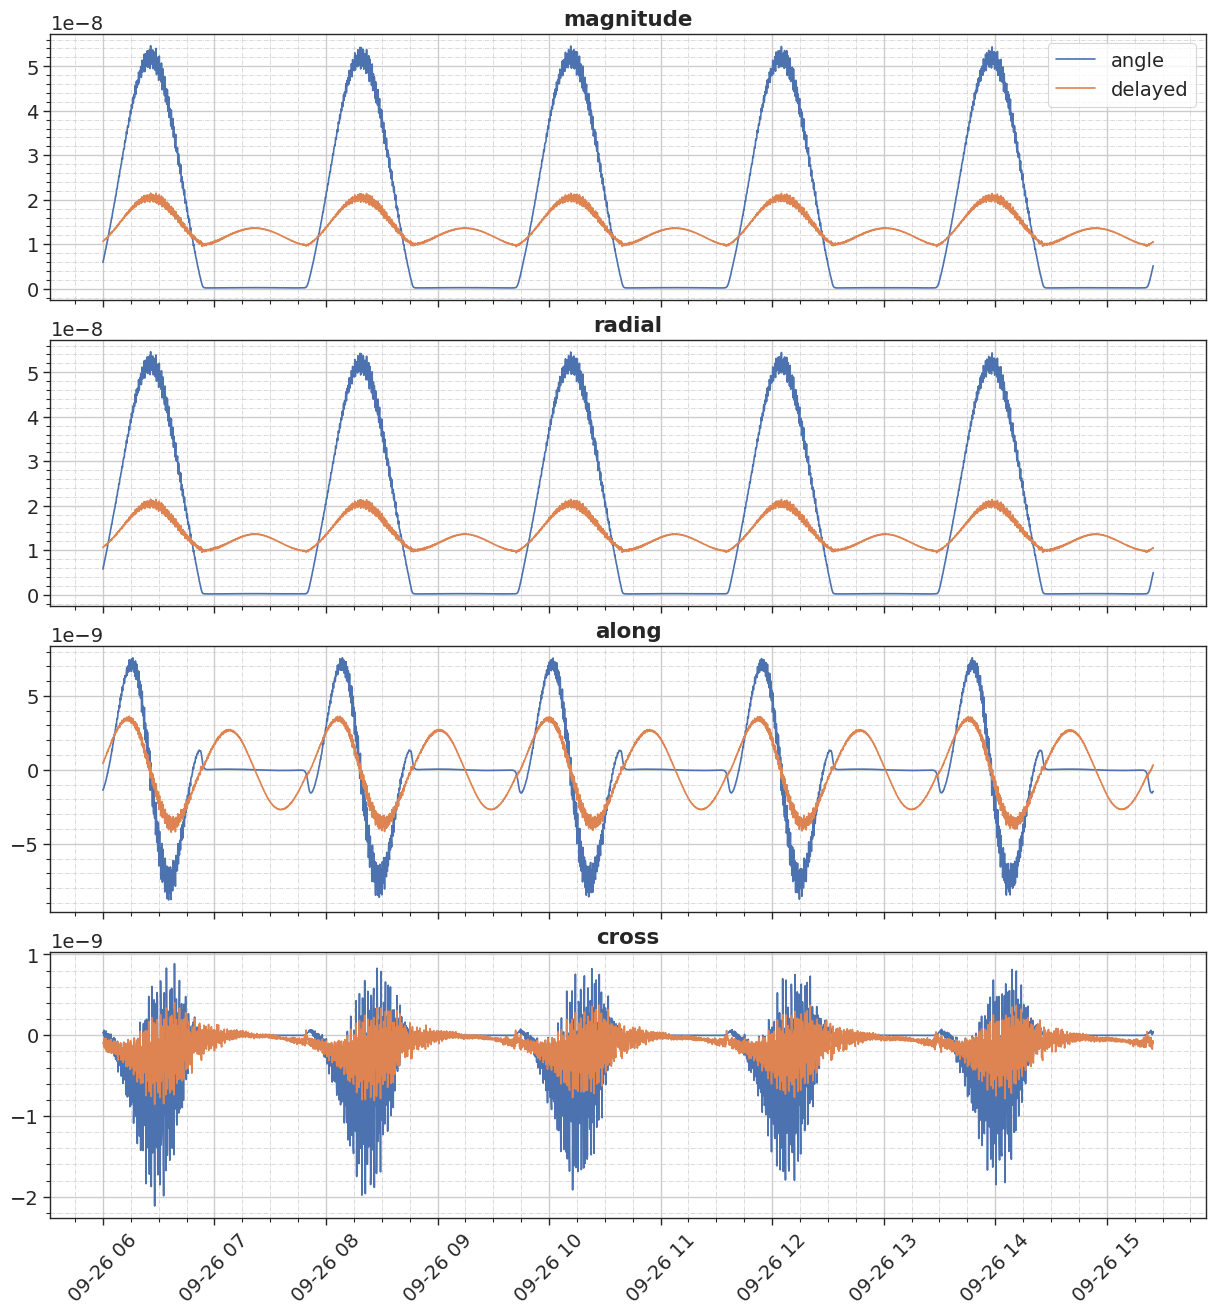

In [11]:
def plot_accelerations(dfs, labels, skip=[], scale_y=1.3):
    fig, axs = plt.subplots(4, 1, figsize=(12, 10*scale_y), sharex="all")
    ax_mag, ax_radial, ax_along, ax_cross = axs

    for df, label in zip(dfs, labels):
        if label in skip:
            continue
        ax_mag.plot(df.index, df["acc_rp_moon"], label=label)
        ax_radial.plot(df.index, df["acc_rp_moon_radial"])
        ax_along.plot(df.index, df["acc_rp_moon_along"])
        ax_cross.plot(df.index, df["acc_rp_moon_cross"])

    ax_mag.set_title("magnitude")
    ax_radial.set_title("radial")
    ax_along.set_title("along")
    ax_cross.set_title("cross")
    ax_mag.legend()

    for ax in axs.flat:
        ax.tick_params(axis='x', labelrotation=45)
        ax.set_ylim([min(0, ax.get_ylim()[0]), ax.get_ylim()[1]])
    
    format_plot()

plot_accelerations([run_angle, run_knocke], ["angle", "delayed"])

In [12]:
run_angle["acc_rp_moon"].min()

1.6504660190648173e-10